### _V18_ $ $ Der Germanium-Detektor

#### Vorläufige Auswertung

##### Pakete importieren

In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values as noms, std_devs as stds, uarray as uar

plt.rcParams['figure.figsize']                 = [8,5]
plt.rcParams['figure.constrained_layout.use']  = True
plt.rcParams['legend.frameon']                 = False
plt.rcParams["xtick.minor.visible"]            = True
plt.rcParams["ytick.minor.visible"]            = True

##### Messdaten einlesen

In [2]:
eu = np.genfromtxt('data/test/eu.Spe', unpack=True, skip_header=12, skip_footer=14)
cs = np.genfromtxt('data/test/cs.Spe', unpack=True, skip_header=12, skip_footer=14)
ba_sb = np.genfromtxt('data/test/ba_sb.Spe', unpack=True, skip_header=12, skip_footer=14)
unknown = np.genfromtxt('data/test/unknown.Spe', unpack=True, skip_header=12, skip_footer=14)

##### Messzeiten einlesen

In [3]:
t_eu = np.genfromtxt('data/test/eu.Spe', unpack=True, skip_header=9, skip_footer=8208)
t_cs = np.genfromtxt('data/test/cs.Spe', unpack=True, skip_header=12, skip_footer=14)
t_ba_sb = np.genfromtxt('data/test/ba_sb.Spe', unpack=True, skip_header=12, skip_footer=14)
t_unknown = np.genfromtxt('data/test/unknown.Spe', unpack=True, skip_header=12, skip_footer=14)

#### Eu-152

##### Peaks zuordnen

Peaks: 11

Channel Count

[[ 105.  281.]
 [ 309. 4720.]
 [ 614.  723.]
 [ 861. 1364.]
 [1026.  108.]
 [1108.  140.]
 [1939.  188.]
 [2400.  158.]
 [2703.   89.]
 [2765.  113.]
 [3501.  112.]]


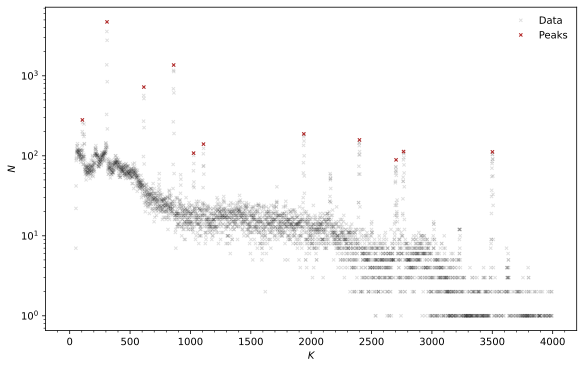

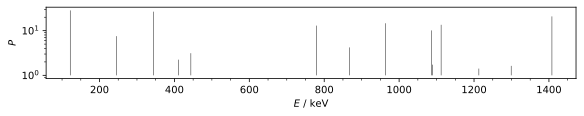

In [4]:
eu_E, eu_P = np.genfromtxt('data/eu-lit.txt', unpack=True)

eu_K = np.arange(len(eu))

eu_peak_ind = find_peaks(eu, distance=50, prominence=75)[0]
eu_peak = eu[eu_peak_ind]
eu_K_peak = eu_K[eu_peak_ind]

print(f'Peaks: {len(eu_peak_ind)}\n')
print(f'Channel Count\n')
print(f'{np.vstack((eu_K_peak, eu_peak)).T}')
    
plt.plot(eu_K[:4000], eu[:4000], 'kx', ms=3.21, alpha=0.125, label='Data')
plt.plot(eu_K_peak, eu_peak, 'x', c='firebrick', ms=3.21, label='Peaks')

plt.xlabel(r'$K$')
plt.ylabel(r'$N$')
plt.yscale('log')
plt.legend()

plt.show()
plt.close()

plt.figure(figsize=[8, 1.5])

plt.vlines(eu_E, 1, eu_P * 100, 'k', lw=0.45)

plt.xlabel(r'$E$ / keV')
plt.ylabel(r'$P$')
plt.yscale('log')

plt.show()
plt.close()

eu_peak_ass = eu_peak[np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]
eu_K_peak_ass = eu_K_peak[np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]
eu_E_ass = eu_E[np.array([0, 1, 2, 3, 4, 5, 7, 8, 10, 13])]
eu_P_ass = eu_P[np.array([0, 1, 2, 3, 4, 5, 7, 8, 10, 13])]

##### Energie kalibrieren

Linear Fit: E(K) = aK + b

a = ( 0.4029 +- 0.0001) keV
b = (-2.5619 +- 0.2319) keV


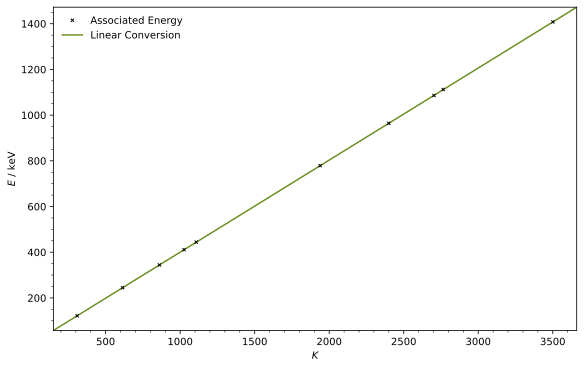

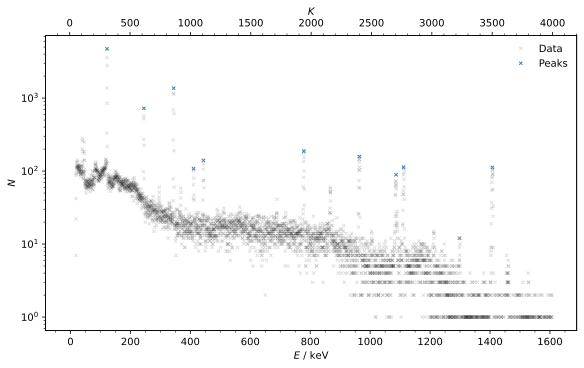

In [5]:
par, cov = np.polyfit(eu_K_peak_ass, eu_E_ass, deg=1, cov=True)
err = np.sqrt(np.diag(cov))

a, b = par
aerr, berr = err

print(f'Linear Fit: E(K) = aK + b\n')
print(f'a = ( {a:.4f} +- {aerr:.4f}) keV')
print(f'b = ({b:.4f} +- {berr:.4f}) keV')

def E(K):
    return a * K + b

plt.plot(eu_K_peak_ass, eu_E_ass, 'kx', ms=3.21, zorder=10, label='Associated Energy')

plt.xlim(plt.xlim())
plt.ylim(plt.ylim())

x = np.array([-1e4, +1e4])

plt.plot(x, a * x + b, c='olivedrab', zorder=0, label='Linear Conversion')

plt.xlabel(r'$K$')
plt.ylabel(r'$E$ / keV')
plt.legend()

plt.show()
plt.close()

eu_K_in_E = E(eu_K)
eu_K_peak_ass_in_E = E(eu_K_peak_ass)

plt.plot(eu_K_in_E[:4000], eu[:4000], 'kx', ms=3.21, alpha=0.125, label='Data')
plt.plot(eu_K_peak_ass_in_E, eu_peak_ass, 'x', c='steelblue', ms=3.21, label='Peaks')

plt.xlabel(r'$E$ / keV')
plt.ylabel(r'$N$')
plt.legend()

plt.gca().twiny()
plt.plot(eu_K[[0, 4000]], eu[[0, 4000]], alpha=0)

plt.xlabel(r'$K$')
plt.yscale('log')

plt.show()
plt.close()

##### Effizienz modellieren

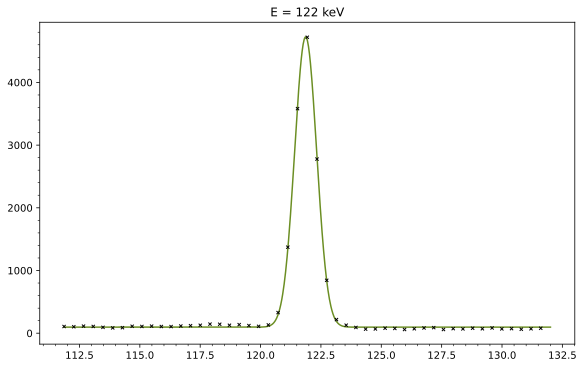

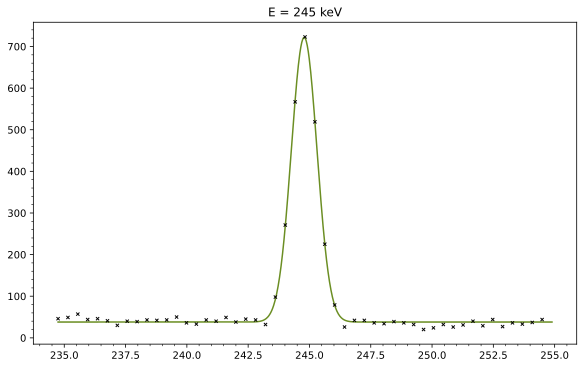

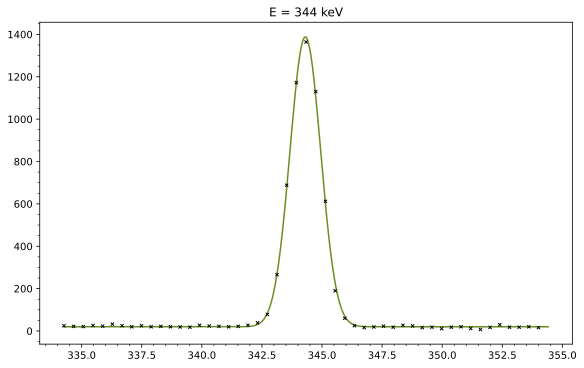

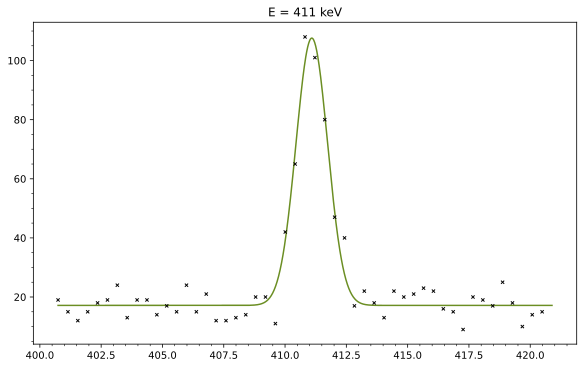

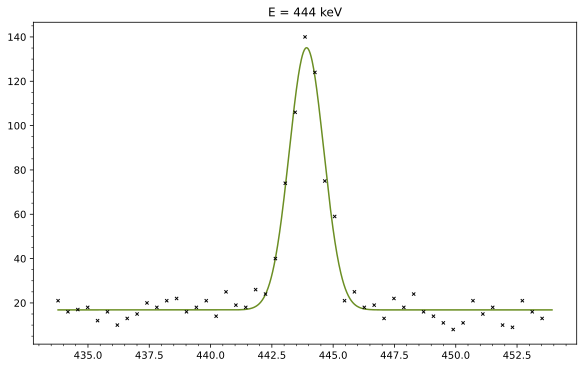

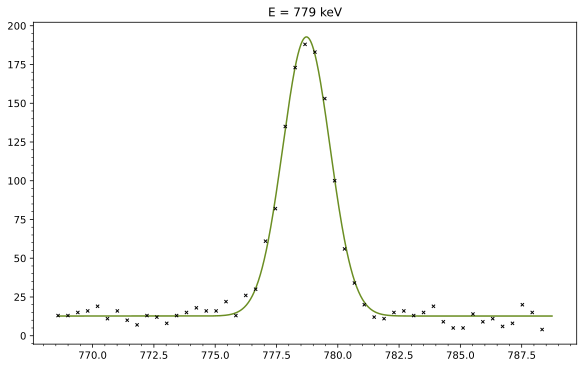

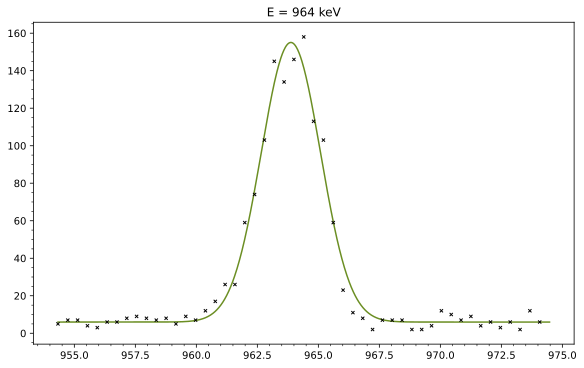

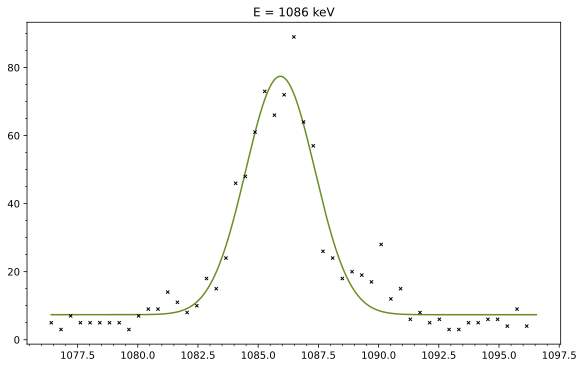

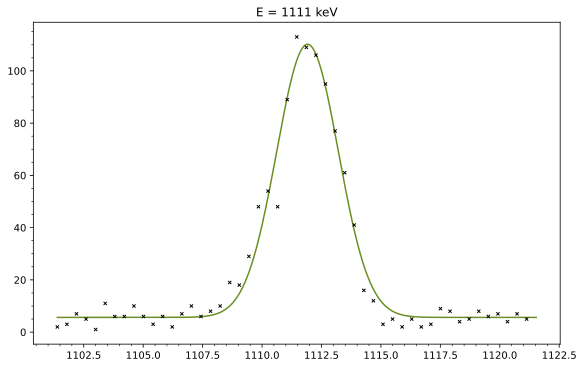

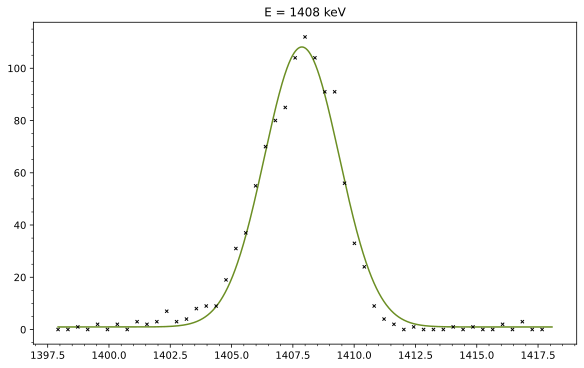

In [6]:
def gaussbg(x, b, m, s, N):
    return b + N / np.sqrt(2 * np.pi * s**2) * np.e**(-(x - m)**2 / (2 * s**2))

for row in zip(eu_K_peak_ass, eu_K_peak_ass_in_E, eu_peak_ass):
    K_lo = row[0] - 25
    K_hi = row[0] + 25

    m0 = row[1]
    N0 = row[2]

    par, cov = curve_fit(gaussbg, eu_K_in_E[K_lo:K_hi], eu[K_lo:K_hi], p0=[1, m0, 1, N0])

    x = np.linspace(eu_K_in_E[K_lo], eu_K_in_E[K_hi], 1000)

    plt.plot(x, gaussbg(x, *par), c='olivedrab', label='Fit')
    plt.plot(eu_K_in_E[K_lo:K_hi], eu[K_lo:K_hi], 'kx', ms=3.21, label='Data')
    
    plt.title(f'E = {m0:.0f} keV')

    plt.show()
    plt.close()